<a href="https://colab.research.google.com/github/chitra-psg/cnn_melanoma/blob/main/melonoma_detection_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

import warnings
warnings.filterwarnings("ignore")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images -Kaggle use
## Todo: Update the paths of the train and test dataset
#root_path = '/kaggle/input/melanoma-isic/Skin cancer ISIC The International Skin Imaging Collaboration'
#data_dir_train = pathlib.Path(root_path + '/Train')
#data_dir_test = pathlib.Path(root_path + '/Test')

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = '/content/gdrive/My Drive/Course/Melanoma_Detection/ISIC'  #change dir to your project folder

data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
          data_dir_train,
          validation_split=0.2,
          subset="training",
          seed=123,
          image_size=(img_height, img_width),
          batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#val_ds = ##todo

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

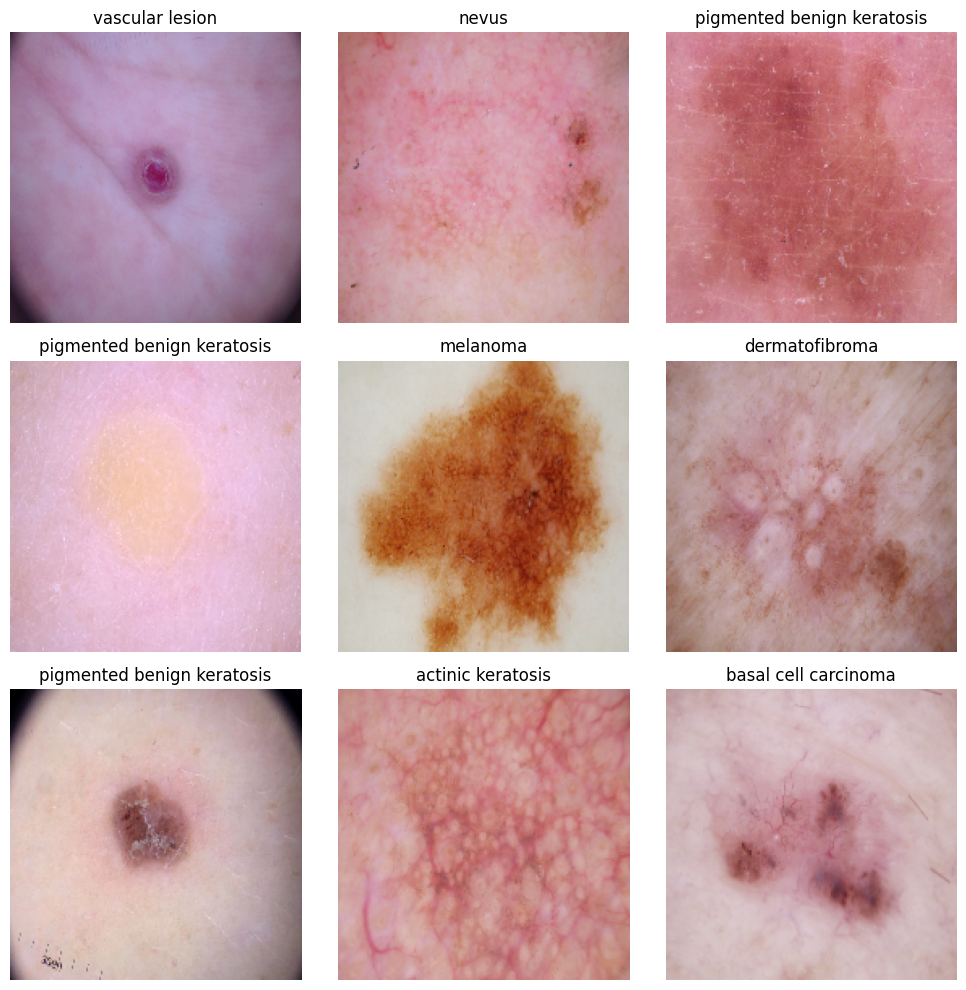

In [8]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
### Your code goes here
model_1 = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.25),

    layers.Dense(units=num_classes, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer= opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [13]:
# View the summary of all layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       3

### Train the model

In [14]:
epochs = 20
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 458s 2s/step - loss: 2.0194 - accuracy: 0.2176 - val_loss: 1.7895 - val_accuracy: 0.3512
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6943 - accuracy: 0.3711 - val_loss: 1.7814 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5981 - accuracy: 0.4230 - val_loss: 1.5990 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5332 - accuracy: 0.4464 - val_loss: 1.5103 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.4449 - accuracy: 0.5006 - val_loss: 1.3944 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3780 - accuracy: 0.5184 - val_loss: 1.4109 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3484 - accuracy: 0.5151 - val_loss: 1.3317 - val_accuracy: 0.5257
Epoch 8/20
56

### Visualizing training results

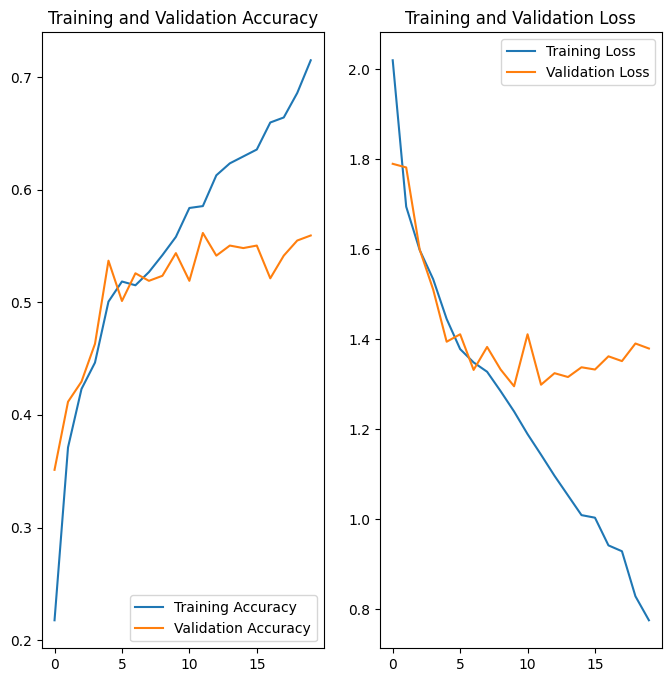

In [15]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [39]:

# Set random seed for reproducibility
seed_value = 42

data_augmentation = tf.keras.Sequential(
  [

    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3), seed=seed_value),
    layers.experimental.preprocessing.RandomRotation(0.1, seed=seed_value),
    layers.experimental.preprocessing.RandomZoom(0.1, seed=seed_value),
  ]
)

# Apply augmentation strategy to the image
#data_augmentation = tf.keras.Sequential(
#  [
#    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
#                                                 input_shape=(img_height,
#                                                              img_width,
#                                                              3)),
#    layers.experimental.preprocessing.RandomRotation(0.2),
#    layers.experimental.preprocessing.RandomZoom(0.2),
#    layers.experimental.preprocessing.RandomContrast(0.1)
#  ]
#)

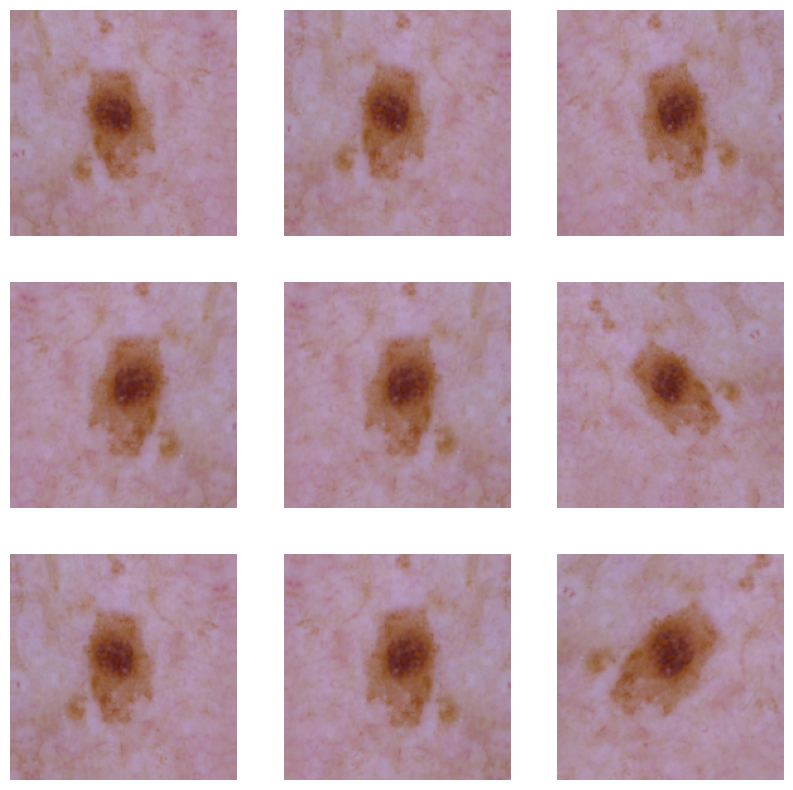

In [40]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# CNN Model with data augmentation
model_2 = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, 2, padding="same", activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(units=num_classes, activation='softmax')
])



### Compiling the model

In [19]:
## Your code goes here

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 49ms/step - loss: 2.0462 - accuracy: 0.2031 - val_loss: 1.9436 - val_accuracy: 0.3087
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 1.8165 - accuracy: 0.3348 - val_loss: 1.7112 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.6764 - accuracy: 0.3767 - val_loss: 1.6122 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6276 - accuracy: 0.4023 - val_loss: 1.5765 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5299 - accuracy: 0.4559 - val_loss: 1.5264 - val_accuracy: 0.4564
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4537 - accuracy: 0.4944 - val_loss: 1.4323 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4375 - accuracy: 0.4838 - val_loss: 1.5618 - val_accuracy: 0.4586
Epoch 8/20
56

### Visualizing the results

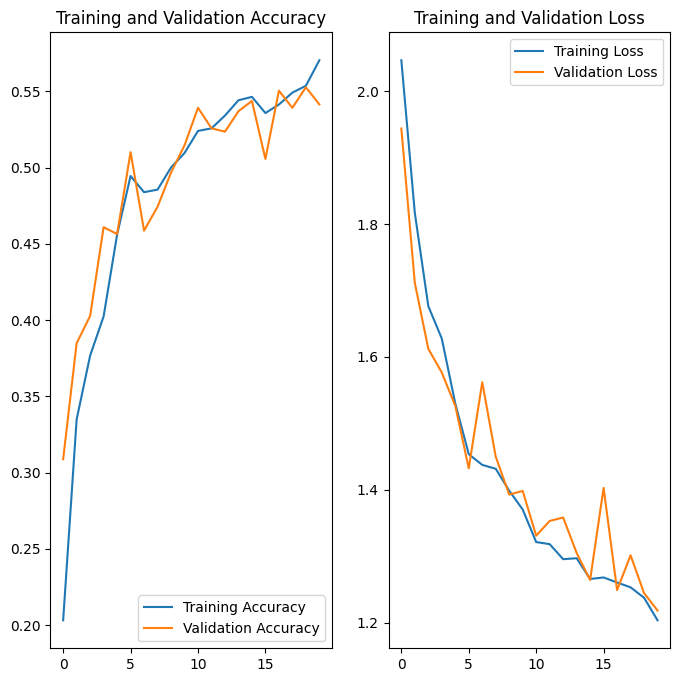

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 800x800 with 0 Axes>

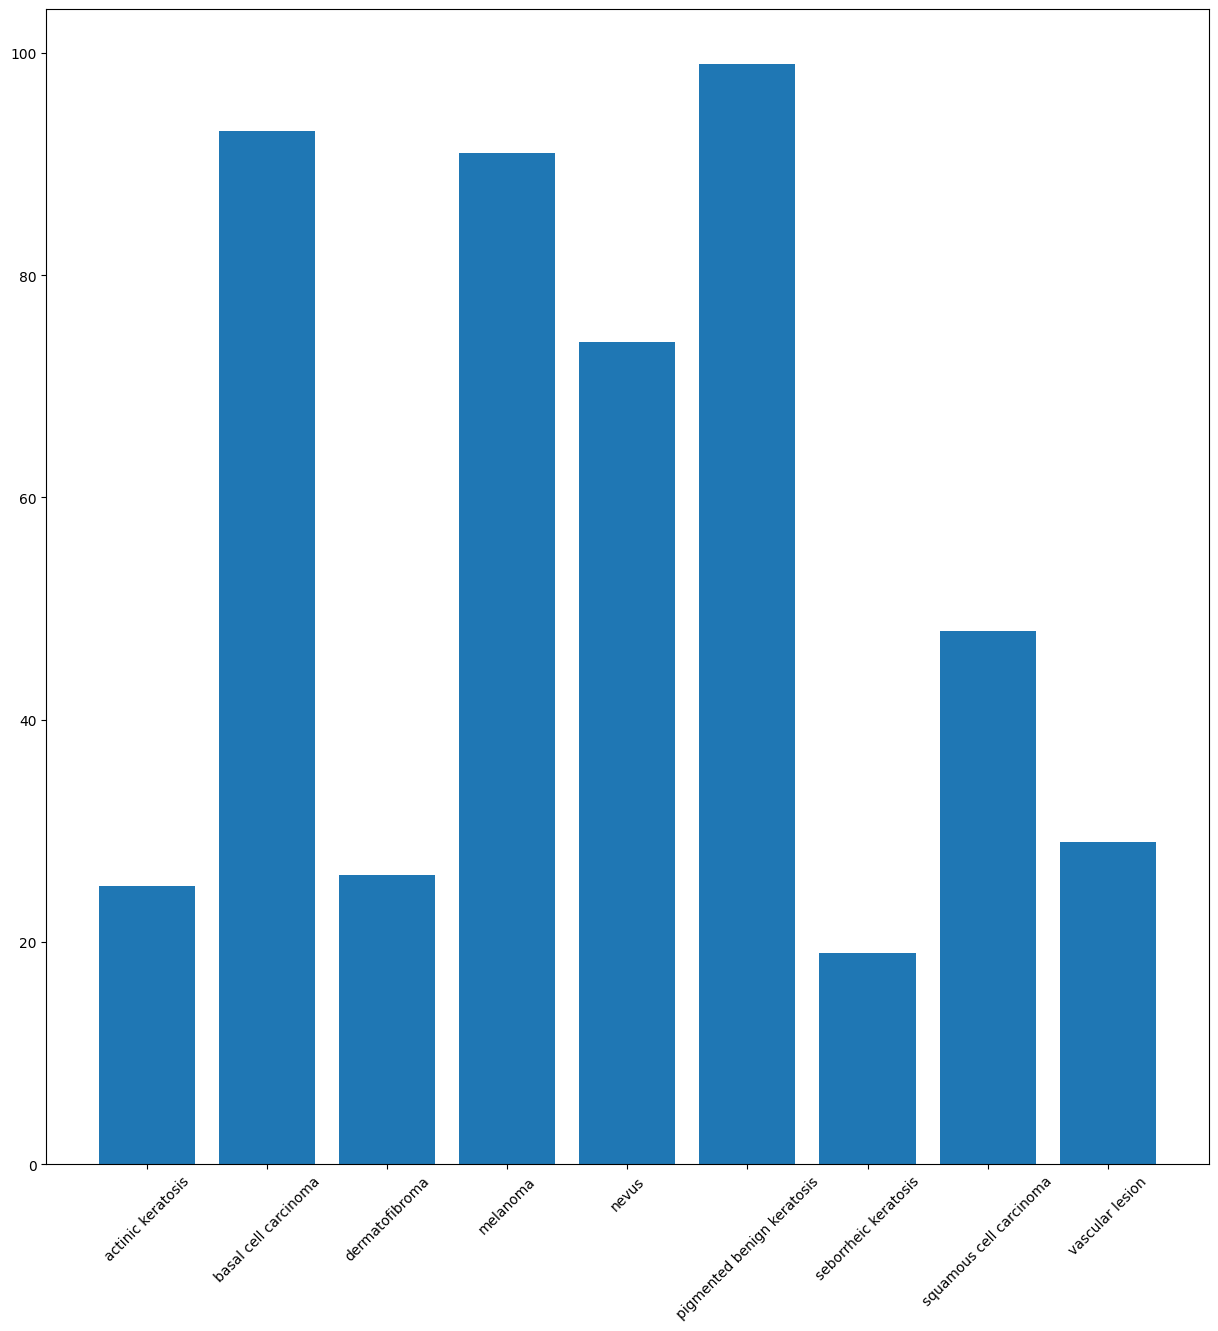

In [22]:
## Your code goes here.
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(8, 8))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [46]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B136020BF70>: 100%|██████████| 500/500 [00:22<00:00, 22.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B1360037490>: 100%|██████████| 500/500 [00:23<00:00, 20.93 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B1374B222C0>: 100%|██████████| 500/500 [00:22<00:00, 22.34 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7B1416FDE3B0>: 100%|██████████| 500/500 [01:55<00:00,  4.32 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7B1374C2E7D0>: 100%|██████████| 500/500 [01:37<00:00,  5.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B13702F74C0>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B1374CB7940>: 100%|██████████| 500/500 [00:52<00:00,  9.52 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B1370326D70>: 100%|██████████| 500/500 [00:21<00:00, 22.97 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Course/Melanoma_Detection/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B13703F4B50>: 100%|██████████| 500/500 [00:22<00:00, 21.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [47]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

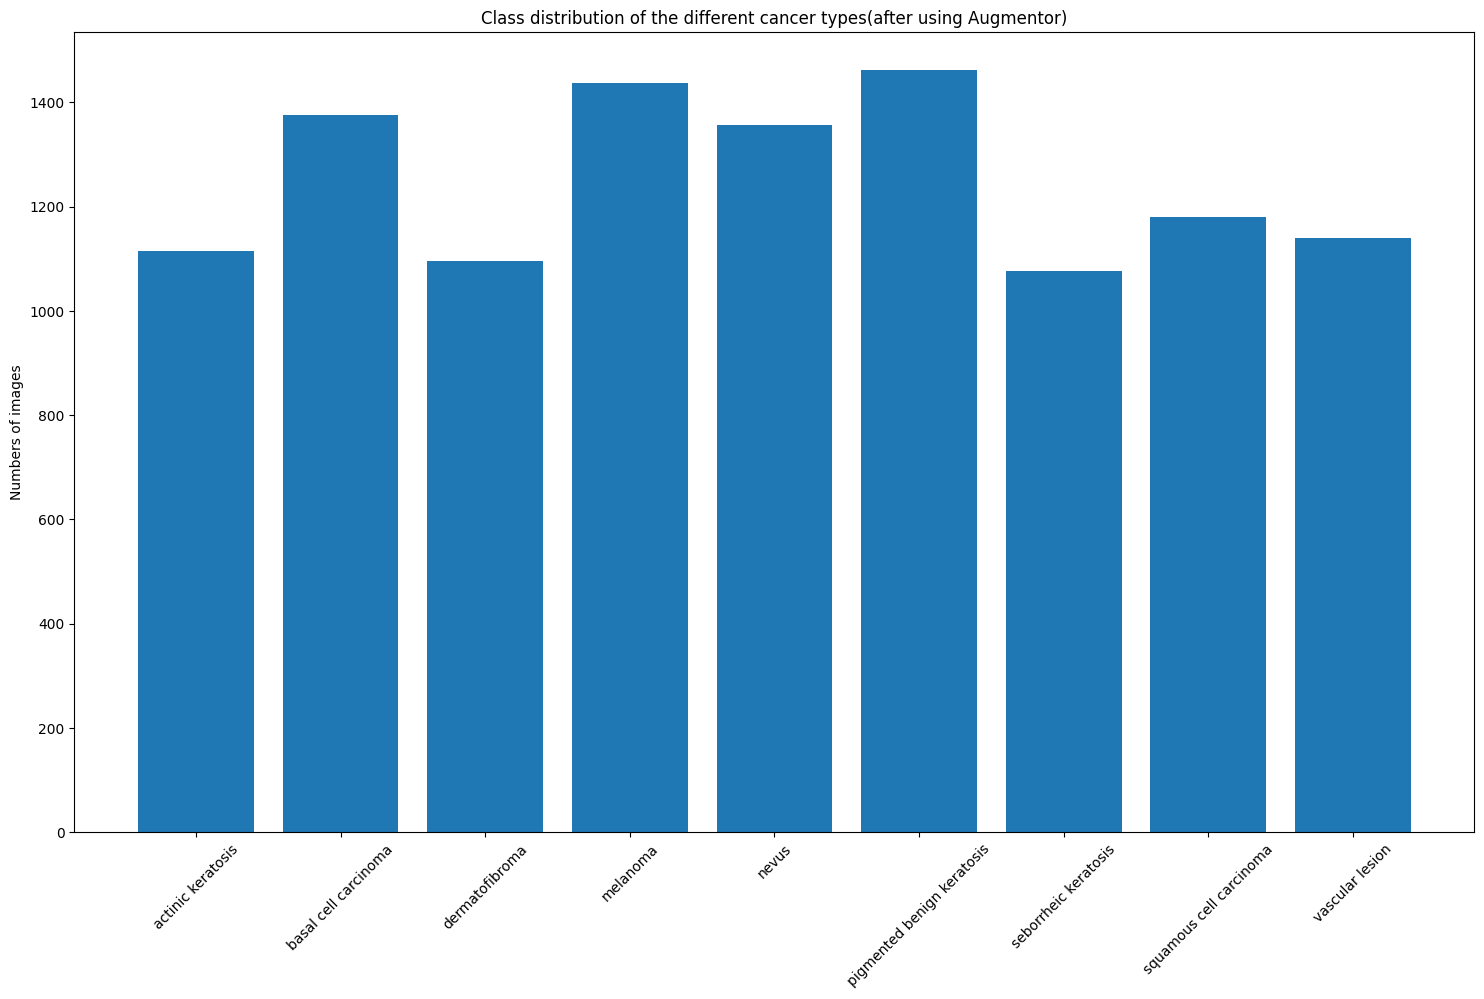

In [48]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) + len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=45)
plt.show()


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

#### **Todo:** Create a training dataset

In [1]:
balanced_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: ignored

#### **Todo:** Create a validation dataset

In [30]:
balanced_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
balanced_train_ds = balanced_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
balanced_val_ds = balanced_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [41]:
# CNN Model with data augmentation and batch normalization

model_3 = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, 2, padding="same"),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(1024, kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(units=num_classes, activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## Your code goes here

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:

epochs = 30
history = model_3.fit(
  balanced_train_ds,
  validation_data=balanced_val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 20s 71ms/step - loss: 7.6222 - accuracy: 0.3858 - val_loss: 3.4310 - val_accuracy: 0.1544
Epoch 2/30
169/169 [==============================] - 11s 68ms/step - loss: 2.7546 - accuracy: 0.4314 - val_loss: 3.6380 - val_accuracy: 0.1433
Epoch 3/30
169/169 [==============================] - 11s 67ms/step - loss: 2.4470 - accuracy: 0.4690 - val_loss: 3.1642 - val_accuracy: 0.2494
Epoch 4/30
169/169 [==============================] - 11s 67ms/step - loss: 2.4428 - accuracy: 0.4835 - val_loss: 2.7919 - val_accuracy: 0.4336
Epoch 5/30
169/169 [==============================] - 11s 67ms/step - loss: 2.3390 - accuracy: 0.5154 - val_loss: 2.8927 - val_accuracy: 0.3697
Epoch 6/30
169/169 [==============================] - 11s 66ms/step - loss: 2.2956 - accuracy: 0.5297 - val_loss: 2.5867 - val_accuracy: 0.4350
Epoch 7/30
169/169 [==============================] - 11s 66ms/step - loss: 2.3160 - accuracy: 0.5184 - val_loss: 5.0894 - val_accuracy:

#### **Todo:**  Visualize the model results

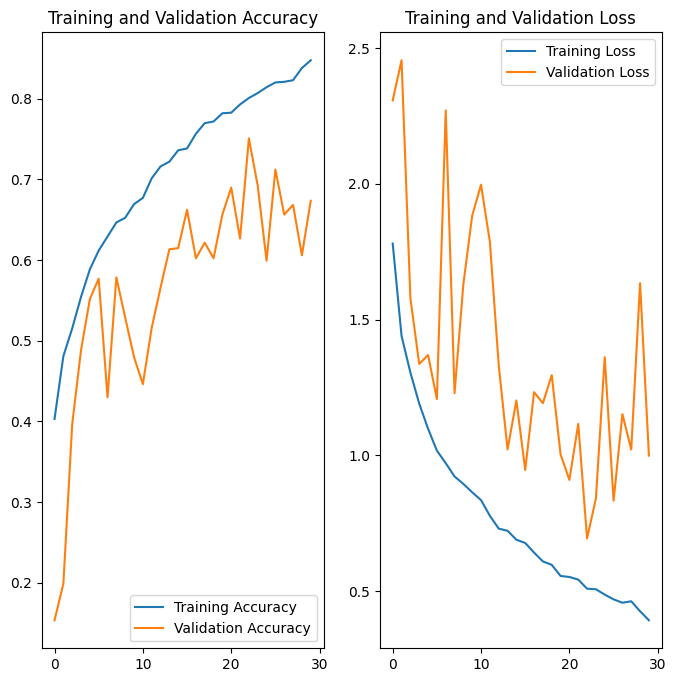

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

